<a href="https://colab.research.google.com/github/Cralsic123/Model-selection-for-abalone-ring/blob/main/VT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.2 MB/s eta 0:00:00


In [11]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.4 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer,r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, cross_val_predict
from xgboost import XGBRegressor, cv
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from scipy.stats import norm, skew
import optuna
from sklearn.ensemble import VotingRegressor

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c playground-series-s4e4

  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 160MB/s]


In [7]:
import zipfile
with zipfile.ZipFile('/content/playground-series-s4e4.zip', 'r') as zip_ref:
    zip_ref.extractall('./')



In [13]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

This time im gonna use the actual abalone dataset


In [14]:
train_org = pd.read_csv('/content/abalone.csv')

In [15]:
train_org.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [16]:
train_org = train_org.rename(columns={'Shucked weight': 'Whole weight.1',
                                      'Viscera weight': 'Whole weight.2'})

In [17]:
train = pd.concat([train, train_org]).drop(['id'], axis=1).drop_duplicates()
test = test.drop(['id'], axis=1)

In [19]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


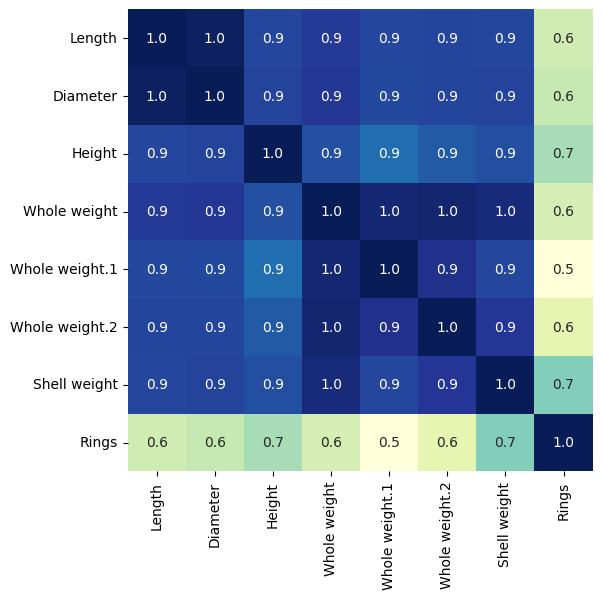

In [20]:
f, ax = plt.subplots(figsize=(6, 6))
corr = train.select_dtypes(exclude='object').corr(method='pearson')
sns.heatmap(corr, ax=ax, fmt = '0.1f', cmap = 'YlGnBu', annot=True, cbar=False)
plt.show()